In [1]:
# Install external libraries
!pip install umap-learn
!pip install shap

# General libraries
import pandas as pd
import numpy as np
import os
import umap.umap_ as umap
import random as python_random
from scipy.stats import normaltest, pearsonr

# Google library
#from google.colab import drive

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set seeds
umap_limit=1
seed_value=13
tf.random.set_seed(seed_value)
python_random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

# Check if gpu is enabled
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Num GPUs Available:  0


# **Load Dataset**







In [2]:
# Rosetta data
df_energy = pd.read_csv("data/Rueben_504.csv")


In [3]:
print(df_energy.columns)

Index(['total_score', 'Sc', 'Sc_int_area', 'complex_normalized', 'dG_cross',
       'dG_cross/dSASAx100', 'dG_separated', 'dG_separated/dSASAx100',
       'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'ddg', 'delta_unsatHbonds',
       'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'hbond_E_fraction',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hbonds_int',
       'lk_ball_wtd', 'nres_all', 'nres_int', 'omega', 'p_aa_pp',
       'per_residue_energy_int', 'pro_close', 'rama_prepro', 'ref', 'sc_value',
       'side1_normalized', 'side1_score', 'side2_normalized', 'side2_score',
       'pdb_id', 'resolution', 'kd_molar'],
      dtype='object')


In [4]:
# Remove 'SCORE:' and 'description' column
df_energy.drop(columns=['pdb_id', 'resolution'], axis=1, inplace=True)
df_energy['DG'] = (1.987*298.15*np.log(df_energy['kd_molar'])/1000)
df_energy.drop(columns=['kd_molar'], axis=1, inplace=True)

In [5]:
print(df_energy.columns)

Index(['total_score', 'Sc', 'Sc_int_area', 'complex_normalized', 'dG_cross',
       'dG_cross/dSASAx100', 'dG_separated', 'dG_separated/dSASAx100',
       'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'ddg', 'delta_unsatHbonds',
       'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'hbond_E_fraction',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hbonds_int',
       'lk_ball_wtd', 'nres_all', 'nres_int', 'omega', 'p_aa_pp',
       'per_residue_energy_int', 'pro_close', 'rama_prepro', 'ref', 'sc_value',
       'side1_normalized', 'side1_score', 'side2_normalized', 'side2_score',
       'DG'],
      dtype='object')


# **Model Training**

In [6]:
df_vhhs = pd.read_csv("data/validation_set/Contini_20_testset.csv")
df_vhhs.drop(columns=['description', 'packstat', 'yhh_planarity'], inplace=True)

df_train = df_energy.copy()
df_test = df_vhhs.copy()

In [7]:
print(df_vhhs)


    total_score        Sc  Sc_int_area  complex_normalized   dG_cross  \
0   -786.471369  0.721062   966.689209           -2.627289 -51.378883   
1  -1058.437165 -1.000000    -1.000000           -2.682545   0.000000   
2   -514.431114  0.749077   699.126251           -2.793660 -46.532150   
3  -1371.085529 -1.000000    -1.000000           -2.411634   0.000000   
4   -613.745529 -1.000000    -1.000000           -2.897528   0.000000   
5   -691.749745  0.739765  1076.744263           -2.516733 -61.022839   
6    150.622818 -1.000000    -1.000000            0.199613   0.000000   
7   -827.387244  0.601674   741.166412           -2.716228 -31.896444   
8  -1189.595010 -1.000000    -1.000000           -3.622134   0.000000   
9   -640.819193 -1.000000    -1.000000           -1.827858   0.000000   
10  -733.033359  0.665697   729.659393           -2.306123 -39.410877   
11  -720.472057  0.635050  1346.186523           -2.308234 -67.585022   
12  -714.850876 -1.000000    -1.000000           -2

In [8]:
# Count rows in X_train with any NaNs
num_nan_rows_train = df_train.isnull().any(axis=1).sum()
print(f"X_train contains {num_nan_rows_train} rows with NaN values.")

# Count rows in X_test with any NaNs
num_nan_rows_test = df_test.isnull().any(axis=1).sum()
print(f"X_test contains {num_nan_rows_test} rows with NaN values.")

X_train contains 1 rows with NaN values.
X_test contains 0 rows with NaN values.


In [9]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [10]:
# Count rows in X_train with any NaNs
num_nan_rows_train = df_train.isnull().any(axis=1).sum()
print(f"X_train contains {num_nan_rows_train} rows with NaN values.")

# Count rows in X_test with any NaNs
num_nan_rows_test = df_test.isnull().any(axis=1).sum()
print(f"X_test contains {num_nan_rows_test} rows with NaN values.")

X_train contains 0 rows with NaN values.
X_test contains 0 rows with NaN values.


In [11]:
X = df_train.drop(columns=['DG'], axis=1) 
y = df_train["DG"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25,
                     random_state=seed_value,
                     shuffle=True)

In [12]:
scaler = MinMaxScaler() 
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),
                      index=X_test.index, columns=X_test.columns)
                      

# UMAP Dimensionality Reduction
umap_dict = {}

for i in range(umap_limit):

    reducer = umap.UMAP(
        n_components=15, n_neighbors=20, random_state=42, transform_seed=42, verbose=False
    )

    X_t = reducer.fit_transform(X_train)
    X_t = pd.DataFrame(data=X_t, columns=[f"column_{i}" for i in range(X_t.shape[1])])

    X_te = reducer.transform(X_test)
    X_te = pd.DataFrame(data=X_te, columns=[f"column_{i}" for i in range(X_te.shape[1])])

    umap_dict[str(i)] = (X_t, X_te, reducer)


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [13]:
len(X_train.columns)

41

## Neural Network training

### Tune Neural Network Hyperparameters


=== Training 4-layer ([4, 10, 8, 12]) ===


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_


=== Training 3-layer ([4, 8, 12]) ===


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_


=== Training 2-layer ([4, 12]) ===


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_

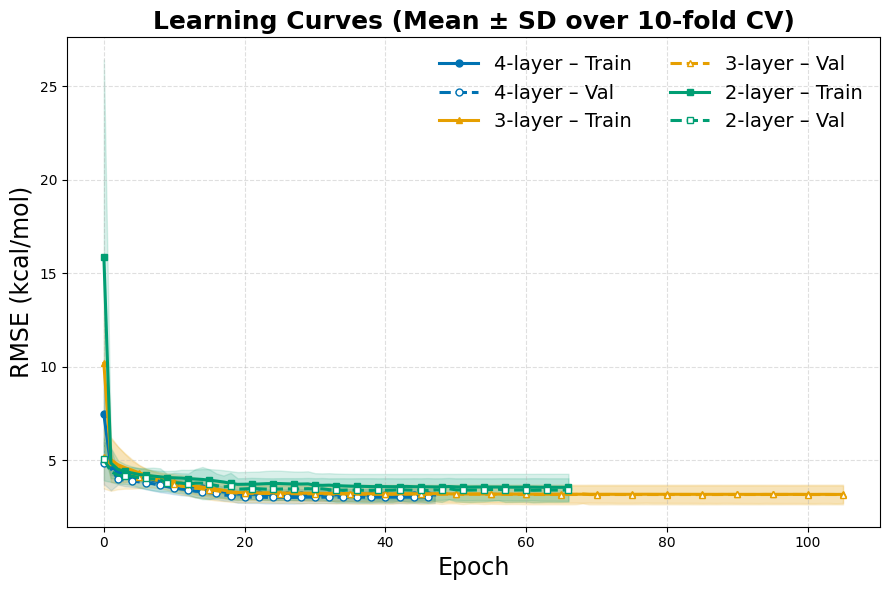

Saved: ./learning_curve_comparison/learning_curves_mean_sd.png


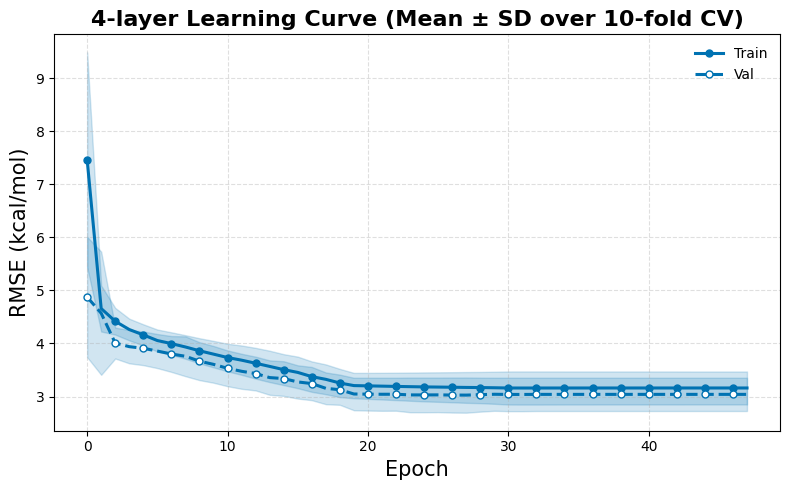

Saved: ./learning_curve_comparison/learning_curve_4layer.png


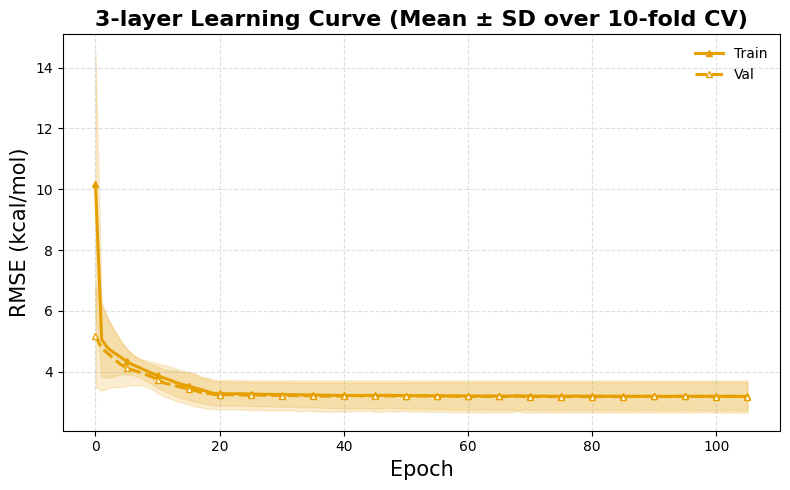

Saved: ./learning_curve_comparison/learning_curve_3layer.png


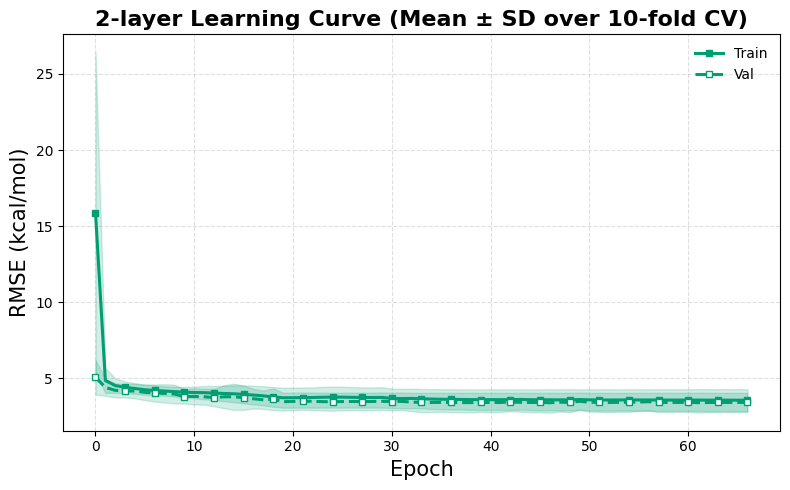

Saved: ./learning_curve_comparison/learning_curve_2layer.png

Validation Metrics (final) per model:
         RMSE_mean  RMSE_std  MAE_mean  MAE_std   n
model                                              
2-layer      4.693     1.385     3.843    1.363  10
3-layer      5.032     1.915     4.088    2.015  10
4-layer      4.626     1.400     3.766    1.492  10


In [21]:
# %% Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error  # <-- MAE

# ===================== USER CONFIG =====================
RANDOM_STATE = 42
N_SPLITS = 10
EPOCHS = 200
BATCH_SIZE = 3
LEARNING_RATE = 0.01
RESULTS_DIR = "./learning_curve_comparison"

# X: pd.DataFrame of shape (n_samples, n_features)
# y: pd.Series of shape (n_samples,)
# X = ...
# y = ...
# ======================================================

os.makedirs(RESULTS_DIR, exist_ok=True)

# Colorblind-friendly palette (Okabe–Ito)
CB_COLORS = {
    "4-layer": "#0072B2",  # blue
    "3-layer": "#E69F00",  # orange
    "2-layer": "#009E73",  # bluish green
}

# Distinct markers per model
CB_MARKERS = {
    "4-layer": "o",  # circle
    "3-layer": "^",  # triangle
    "2-layer": "s",  # square
}

def scheduler(epoch, lr):
    return float(lr * np.exp(-0.1)) if epoch in [5, 50, 150] else float(lr)

def build_model(input_dim, layer_sizes):
    model = keras.Sequential()
    model.add(layers.Dense(layer_sizes[0], activation="relu",
                           kernel_initializer="he_uniform", input_dim=input_dim))
    for h in layer_sizes[1:]:
        model.add(layers.Dense(h, activation="relu", kernel_initializer="he_uniform"))
    model.add(layers.Dense(1, activation="linear", kernel_initializer="uniform"))
    opt = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss="mse", metrics=["mse"])
    return model

def train_one_model(X, y, layer_sizes, name):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse", patience=20, restore_best_weights=True
    )
    histories, fold_metrics = [], []
    fold_id = 1
    for train_idx, val_idx in kf.split(X, y):
        model = build_model(X.shape[1], layer_sizes)
        history = model.fit(
            X.iloc[train_idx], y.iloc[train_idx],
            validation_data=(X.iloc[val_idx], y.iloc[val_idx]),
            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
            callbacks=[lr_callback, es_callback], shuffle=True
        )
        h = pd.DataFrame(history.history)
        ep = np.arange(len(h))
        train_rmse = np.sqrt(h["mse"].to_numpy())
        val_rmse   = np.sqrt(h["val_mse"].to_numpy())
        histories.append({
            "fold": fold_id, "epoch": ep, "train_rmse": train_rmse, "val_rmse": val_rmse
        })

        # Predictions
        y_val_pred = model.predict(X.iloc[val_idx], verbose=0).ravel()
        y_val_true = y.iloc[val_idx].to_numpy().ravel()

        # Metrics per fold
        rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
        mae  = mean_absolute_error(y_val_true, y_val_pred)

        fold_metrics.append({
            "model": name,
            "fold": fold_id,
            "final_val_rmse": rmse,
            "final_val_mae": mae
        })
        fold_id += 1
    return histories, fold_metrics

def pad_and_stack(histories, key):
    max_T = max(len(h[key]) for h in histories)
    arrs = []
    for h in histories:
        v = h[key]
        if len(v) < max_T:
            pad = np.full(max_T - len(v), v[-1])
            v = np.concatenate([v, pad])
        arrs.append(v)
    return np.stack(arrs, axis=0)

def plot_learning_curves(all_results):
    """Combined figure: mean ± SD across folds for train & val RMSE for all models."""
    plt.figure(figsize=(9, 6))

    # Fixed order for legend/readability
    for name in ["4-layer", "3-layer", "2-layer"]:
        if name not in all_results:
            continue
        payload   = all_results[name]
        histories = payload["histories"]
        color     = CB_COLORS.get(name, payload.get("color", "#333333"))
        marker    = CB_MARKERS.get(name, "o")

        train_stack = pad_and_stack(histories, "train_rmse")
        val_stack   = pad_and_stack(histories, "val_rmse")
        T = train_stack.shape[1]
        epochs = np.arange(T)

        tr_mean, tr_std = train_stack.mean(axis=0), train_stack.std(axis=0)
        va_mean, va_std = val_stack.mean(axis=0), val_stack.std(axis=0)

        # Train (solid) with filled markers
        plt.plot(
            epochs, tr_mean,
            label=f"{name} – Train",
            color=color, linestyle="-", linewidth=2.2,
            marker=marker, markersize=5, markevery=max(1, T // 20),
        )
        plt.fill_between(epochs, tr_mean - tr_std, tr_mean + tr_std,
                         color=color, alpha=0.15)

        # Val (dashed) with hollow markers
        plt.plot(
            epochs, va_mean,
            label=f"{name} – Val",
            color=color, linestyle="--", linewidth=2.2,
            marker=marker, markersize=5, markevery=max(1, T // 20),
            markerfacecolor="white"
        )
        plt.fill_between(epochs, va_mean - va_std, va_mean + va_std,
                         color=color, alpha=0.15)

    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("RMSE (kcal/mol)", fontsize=17)
    plt.title("Learning Curves (Mean ± SD over 10-fold CV)", fontsize=18, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(ncol=2, fontsize=14, frameon=False)
    plt.tight_layout()
    out_png = os.path.join(RESULTS_DIR, "learning_curves_mean_sd.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_png}")

def plot_learning_curves_per_model(all_results):
    """Separate figure per model: mean ± SD across folds for that model only."""
    for name in ["4-layer", "3-layer", "2-layer"]:
        if name not in all_results:
            continue
        histories = all_results[name]["histories"]
        color     = CB_COLORS[name]
        marker    = CB_MARKERS[name]

        train_stack = pad_and_stack(histories, "train_rmse")
        val_stack   = pad_and_stack(histories, "val_rmse")
        T = train_stack.shape[1]
        epochs = np.arange(T)

        tr_mean, tr_std = train_stack.mean(axis=0), train_stack.std(axis=0)
        va_mean, va_std = val_stack.mean(axis=0), val_stack.std(axis=0)

        plt.figure(figsize=(8, 5))
        # Train
        plt.plot(
            epochs, tr_mean,
            label="Train",
            color=color, linestyle="-", linewidth=2.2,
            marker=marker, markersize=5, markevery=max(1, T // 20),
        )
        plt.fill_between(epochs, tr_mean - tr_std, tr_mean + tr_std,
                         color=color, alpha=0.18)
        # Val
        plt.plot(
            epochs, va_mean,
            label="Val",
            color=color, linestyle="--", linewidth=2.2,
            marker=marker, markersize=5, markevery=max(1, T // 20),
            markerfacecolor="white"
        )
        plt.fill_between(epochs, va_mean - va_std, va_mean + va_std,
                         color=color, alpha=0.18)

        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("RMSE (kcal/mol)", fontsize=15)
        plt.title(f"{name} Learning Curve (Mean ± SD over 10-fold CV)", fontsize=16, fontweight="bold")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend(frameon=False)
        plt.tight_layout()
        out_png = os.path.join(RESULTS_DIR, f"learning_curve_{name.replace('-', '')}.png")
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Saved: {out_png}")

def run_experiment(X, y):
    model_specs = {
        "4-layer": [4, 10, 8, 12],  # your original UMAP-reduced setup
        "3-layer": [4, 8, 12],
        "2-layer": [4, 12],
    }

    all_results = {}
    all_folds = []
    for name, layer_sizes in model_specs.items():
        print(f"\n=== Training {name} ({layer_sizes}) ===")
        histories, fold_metrics = train_one_model(X, y, layer_sizes, name)
        all_results[name] = {"histories": histories, "color": CB_COLORS[name]}
        all_folds.extend(fold_metrics)

    # Combined plot and per-model plots
    plot_learning_curves(all_results)
    plot_learning_curves_per_model(all_results)

    # Per-fold metrics
    df_folds = pd.DataFrame(all_folds)
    df_folds.to_csv(os.path.join(RESULTS_DIR, "final_val_metrics_per_fold.csv"), index=False)

    # Summary (RMSE + MAE)
    summary = (df_folds.groupby("model")
               .agg(RMSE_mean=("final_val_rmse", "mean"),
                    RMSE_std =("final_val_rmse", "std"),
                    MAE_mean =("final_val_mae",  "mean"),
                    MAE_std  =("final_val_mae",  "std"),
                    n        =("final_val_rmse", "count"))
               )

    print("\nValidation Metrics (final) per model:")
    print(summary.round(3))
    summary.to_csv(os.path.join(RESULTS_DIR, "final_val_metrics_summary.csv"))

# ----------------- RUN -----------------
# Example:
run_experiment(X, y)

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Square Error')
  plt.plot(hist['epoch'], np.sqrt(hist['mse']),
           label='Train Error')
  plt.plot(hist['epoch'], np.sqrt(hist['val_mse']),
           label = 'Val Error')
  plt.ylim([0, 10])
  plt.legend()
  plt.show()
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(4,kernel_initializer='he_uniform',
                        input_dim=X.shape[1],
                        activation='relu'))

    model.add(layers.Dense(10, kernel_initializer='he_uniform',
                           activation='relu'))
    model.add(layers.Dense(8 , kernel_initializer='he_uniform',
                           activation='relu'))
    model.add(layers.Dense(12 , kernel_initializer='he_uniform',
                           activation='relu'))                          
    model.add(layers.Dense(1, activation='linear',
                        kernel_initializer='uniform'))

    adam = tf.keras.optimizers.Adamax(learning_rate=0.01)

    model.compile(optimizer=adam,
                loss='mse',
                metrics=['mse'])

    return model
results_dir="/Users/qingshuzhao/Downloads/PPSUS-main/binding_energy_experiments/data"

def scheduler(epoch, lr):
    if epoch in [5, 50, 150]:
        return float(lr * np.exp(-0.1))
    else:
        return float(lr)

models_dict = {}
rmse_records = []  # Collect per-fold RMSE

with tf.device('/device:GPU:0'):
    for i in range(umap_limit):
        reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

        X = umap_dict[str(i)][0]
        Y = y_train
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed_value)

        models = []
        f_counter = 1

        for train, test in kfold.split(X, Y):
            model = build_model()
            print("\nTraining with fold {}".format(f_counter))
            history = model.fit(
                X.iloc[train], Y.iloc[train], 
                validation_data=(X.iloc[test], Y.iloc[test]),  # use fold split for validation
                epochs=200,
                verbose=0,
                batch_size=3,
                callbacks=[reduce_lr],
                shuffle=True
            )

            # Calculate RMSE for this fold
            y_val_pred = model.predict(X.iloc[test], verbose=0)
            y_val_true = Y.iloc[test]
            rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
            rmse_records.append({'model': f'UMAP_{i}', 'fold': f_counter, 'rmse': rmse})

            models.append(model)
            f_counter += 1
            plot_history(history)

        models_dict[str(i)] = models

# Save RMSE results and plot
rmse_df = pd.DataFrame(rmse_records)
rmse_df.to_csv(os.path.join(results_dir, "rmse_per_fold.csv"), index=False)

In [66]:
print(rmse_df)

    model  fold      rmse
0  UMAP_0     1  2.422250
1  UMAP_0     2  2.300217
2  UMAP_0     3  2.873679
3  UMAP_0     4  2.161979
4  UMAP_0     5  2.064048
5  UMAP_0     6  3.424209
6  UMAP_0     7  2.267130
7  UMAP_0     8  2.801338
8  UMAP_0     9  2.290679
9  UMAP_0    10  2.349533


/var/folders/l3/px3tmzm113q8q08w_5t0ktkm0000gn/T/ipykernel_78460/3027766152.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




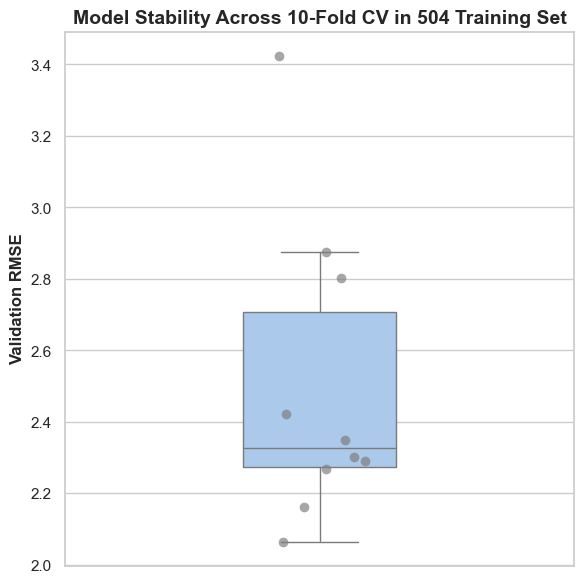

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

rmse_df = pd.read_csv(os.path.join(results_dir, "rmse_per_fold.csv"))

# Set seaborn style
sns.set(style="whitegrid")

# Create boxplot and overlay individual fold points
plt.figure(figsize=(6, 6))
sns.boxplot(x='model', y='rmse', data=rmse_df, width=0.3, palette="pastel", showfliers=False)
sns.stripplot(x='model', y='rmse', data=rmse_df, color='gray', size=7, jitter=True, alpha=0.7, )

# Add labels and title
plt.title('Model Stability Across 10-Fold CV in 504 Training Set', fontsize=14, fontweight='bold')
plt.ylabel('Validation RMSE', fontsize=12, fontweight='bold')
plt.xlabel("")
plt.xticks([])  
plt.tight_layout()
plt.show()

In [68]:
def get_predictions(df, models):
    results = []
    models_std = []
    
    for index, row in df.iterrows():
        r = np.expand_dims(row, axis=0)
        yhats = [m.predict(r)[0][0] for m in models]

        models_std.append(np.std(yhats))
        outcomes = np.mean(yhats)
        results.append(outcomes)

    return results, models_std


# **Test Scoring**

### 12 Benchmark PDBs

In [70]:
for i in range(umap_limit):

    preds = []

    # Use df_vhhs instead of df_test
    X_v = df_vhhs.drop(columns=['DG'], axis=1).copy()
    y_v = df_vhhs["DG"].copy()

    # Scale features
    X_v = pd.DataFrame(
        scaler.transform(X_v),
        index=X_v.index,
        columns=X_v.columns
    )

    # Apply UMAP transformation
    u = umap_dict[str(i)][2]
    X_v = u.transform(X_v)
    X_v = pd.DataFrame(data=X_v, columns=[f"column_{c}" for c in range(X_v.shape[1])])

    # Make predictions
    test_predictions, std = get_predictions(X_v, models_dict[str(i)])

    # Convert target to NumPy
    test = y_v.to_numpy()

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    print("RMSE score:", rmse)
    print("R2 score experimental vs ANN:", r2_score(test, test_predictions))
    print("Pearson correlation experimental vs ANN:", pearsonr(test, test_predictions)[0])

    preds.append((test_predictions, test))

    # Build comparison DataFrame
    df_testV = pd.DataFrame(test)
    df_predV = pd.DataFrame(test_predictions)
    df_errorV = pd.DataFrame(test - test_predictions)
    
    df_comparison = pd.concat([df_testV, df_predV, df_errorV], axis=1)
    df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR"]

    print("\nDF COMPARISON:\n", df_comparison, "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [72]:
# Reload only the description column
description_col = pd.read_csv("/Users/qingshuzhao/Downloads/PPSUS-main/binding_energy_experiments/data/AF_combined.csv", usecols=['description'])

# Assign it back (assuming same row order/index)
df_comparison['description'] = description_col
print(df_comparison)
df_comparison.to_csv(os.path.join(results_dir, "AF_comparison.csv"), index=False)

     REAL  PREDICTED   P_ERROR description
0   -7.53  -9.305168  1.775168        4qo1
1  -11.87  -9.271360 -2.598640        4nbx
2  -12.28  -9.155433 -3.124567        4s10
3  -10.81  -9.589119 -1.220881        4nbz
4  -12.26  -9.209748 -3.050252        4lhj
5  -12.08  -9.636569 -2.443431        2bse
6  -12.75  -9.594895 -3.155105        3g9a
7  -12.59  -9.629185 -2.960815        3k1k
8   -9.85  -9.656509 -0.193491        4c57
9  -10.90  -9.732237 -1.167763        4c59
10 -11.18  -9.660166 -1.519834        4lde
11 -14.01  -9.515290 -4.494710        5hgg


## Nanobodies

In [ ]:
for i in range(umap_limit):

    prodigy_score = pd.read_csv("data/prodigy_vhhs.csv")

    preds = []

    X_v = df_test.drop(columns=['DG'], axis=1).copy() 
    y_v = df_test["DG"].copy() 
    X_v = pd.DataFrame(scaler.transform(X_v),
                    index=X_v.index, columns=X_v.columns)

    u = umap_dict[str(i)][2]

    X_v = u.transform(X_v)
    X_v = pd.DataFrame(data=X_v, columns=[f"column_{c}" for c in range(X_v.shape[1])])

    test_predictions, std = \
        get_predictions(X_v, models_dict[str(i)])

    test = y_v.to_numpy()

    rmse = \
        np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    
    rmse_prodigy = \
        np.sqrt(mean_squared_error(test, prodigy_score[' predicted'].to_numpy(), squared=True))

    print("RMSE score:", rmse)
    print("RMSE score PRODIGY:", rmse_prodigy)
    print("R2 score experimental vs ANN:",
          r2_score(test, test_predictions))
    print("R2 score experimental vs Prodigy:",
          r2_score(test, prodigy_score[' predicted'].to_numpy()))
    print("Pearson correlation experimental vs ANN:",
          pearsonr(test, test_predictions)[0])
    print("Pearson correlation experimental vs Prodigy:",
          pearsonr(test, prodigy_score[' predicted'].to_numpy())[0])

    preds.append((test_predictions, test))

    df_testV = pd.DataFrame(test)
    df_predV = pd.DataFrame(test_predictions)
    df_errorV = pd.DataFrame(test - test_predictions)
    df_prodigy = prodigy_score[' predicted']
    df_prodigy_error = pd.DataFrame(test - df_prodigy.to_numpy())
    df_comparison = pd.concat([df_testV, df_predV, df_errorV, df_prodigy, df_prodigy_error], axis=1)
    df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR", "PRODIGY", "PRODIGY_ERROR"]
    print("\nDF COMPARISON:\n", df_comparison, "\n")

RMSE score: 1.6608713758151015
RMSE score PRODIGY: 2.4302215790081614
R2 score experimental vs ANN: 0.1746893040795512
R2 score experimental vs Prodigy: -0.7670027220878588
Pearson correlation experimental vs ANN: 0.45526635921474173
Pearson correlation experimental vs Prodigy: 0.18083371360752964

DF COMPARISON:
      REAL  PREDICTED   P_ERROR  PRODIGY  PRODIGY_ERROR
0  -10.17  -9.594413 -0.575587    -11.6           1.43
1  -12.17 -11.440682 -0.729318     -9.8          -2.37
2  -11.65 -12.027384  0.377384     -9.6          -2.05
3  -13.80 -11.755001 -2.044999    -12.5          -1.30
4  -10.91 -11.628304  0.718304    -11.3           0.39
5   -8.90 -10.577158  1.677158    -10.6           1.70
6  -12.08  -9.072355 -3.007645     -9.3          -2.78
7  -12.75 -11.851103 -0.898897    -10.5          -2.25
8  -12.59 -10.588088 -2.001912     -8.1          -4.49
9  -10.19 -10.000656 -0.189344     -8.8          -1.39
10 -12.17 -12.313190  0.143190    -10.6          -1.57
11  -9.85  -9.963980  0.

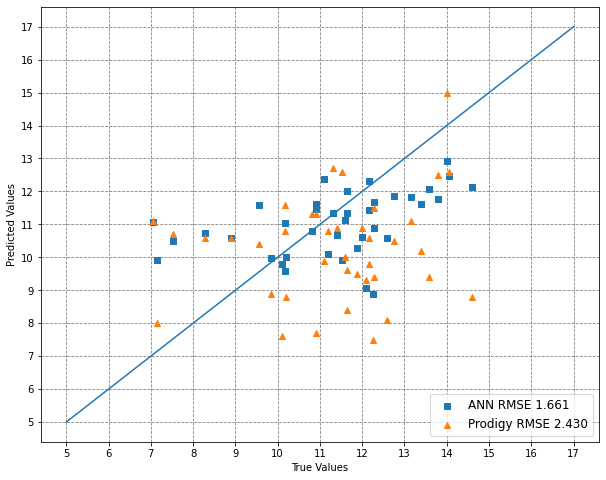

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.axes()

simbols = ['s', '^']

# Article
ax.scatter(np.multiply(test, -1),
           np.multiply(test_predictions, -1), marker=simbols[0])

# Prodigy
ax.scatter(np.multiply(test, -1),
           np.multiply(prodigy_score[' predicted'].to_numpy(), -1),
           marker=simbols[1])

plt.legend(
           (f'ANN RMSE {rmse:.3f}', f'Prodigy RMSE {rmse_prodigy:.3f}'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=12)
ax.plot(range(5, 18), range(5, 18))
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.xticks(range(5, 18))
plt.yticks(range(5, 18))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

plt.show()

## PDBind

In [ ]:
for i in range(umap_limit):

    PDBind_df = pd.read_csv("data/benchmark/validation.csv")
    PDBind_prodigy = pd.read_csv("data/benchmark/prodigy_PDBind.csv")

    # Remove pdb that wasn't accepted by prodigy
    PDBind_df.drop([24], axis=0, inplace=True)
    PDBind_prodigy.drop([24], axis=0, inplace=True)
    PDBind_df = PDBind_df.reset_index(drop=True)
    PDBind_prodigy = PDBind_prodigy.reset_index(drop=True)

    preds = []

    X_v = PDBind_df.drop(columns=['experimental',
                                  'packstat',
                                  'SCORE:',
                                  'yhh_planarity',
                                  'description'], axis=1).copy() 
    y_v = PDBind_df["experimental"].copy() 
    X_v = pd.DataFrame(scaler.transform(X_v),
                    index=X_v.index, columns=X_v.columns)

    u = umap_dict[str(i)][2]

    X_v = u.transform(X_v)
    X_v = pd.DataFrame(data=X_v, columns=[f"column_{c}" for c in range(X_v.shape[1])])

    test_predictions, std = \
        get_predictions(X_v, models_dict[str(i)])

    test = y_v.to_numpy()

    rmse = \
        np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    
    rmse_prodigy = \
        np.sqrt(mean_squared_error(test, PDBind_prodigy['predicted'].astype(float).to_numpy(), squared=True))

    print("RMSE score:", rmse)
    print("RMSE score PRODIGY:", rmse_prodigy)
    print("R2 score experimental vs ANN:",
          r2_score(test, test_predictions))
    print("R2 score experimental vs Prodigy:",
          r2_score(test, PDBind_prodigy['predicted'].astype(float).to_numpy()))
    print("Pearson correlation experimental vs ANN:",
          pearsonr(test, test_predictions)[0])
    print("Pearson correlation experimental vs Prodigy:",
          pearsonr(test, PDBind_prodigy['predicted'].astype(float).to_numpy())[0])
    
    preds.append((test_predictions, test))

    df_testV = pd.DataFrame(test)
    df_predV = pd.DataFrame(test_predictions)
    df_errorV = pd.DataFrame(test - test_predictions)
    df_prodigy = PDBind_prodigy['predicted'].astype(float)
    df_prodigy_error = pd.DataFrame(test - df_prodigy.to_numpy())
    df_comparison = pd.concat([df_testV, df_predV, df_errorV, df_prodigy, df_prodigy_error], axis=1)
    df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR", "PRODIGY", "PRODIGY_ERROR"]
    print("\nDF COMPARISON:\n", df_comparison, "\n")

RMSE score: 2.4459716251742734
RMSE score PRODIGY: 3.586044094109546
R2 score experimental vs ANN: -0.6252807183680975
R2 score experimental vs Prodigy: -2.4934682819686396
Pearson correlation experimental vs ANN: -0.11466359271399248
Pearson correlation experimental vs Prodigy: -0.08264119899508117

DF COMPARISON:
      REAL  PREDICTED   P_ERROR  PRODIGY  PRODIGY_ERROR
0  -10.50  -9.787905 -0.712095     -9.4          -1.10
1   -8.31 -10.572384  2.262384     -6.8          -1.51
2  -10.25  -8.015894 -2.234106     -7.3          -2.95
3   -9.17 -12.005278  2.835278    -13.4           4.23
4  -11.92 -12.037804  0.117804    -15.6           3.68
5   -8.95 -11.168412  2.218412     -7.7          -1.25
6   -9.55  -9.265936 -0.284064    -11.1           1.55
7  -10.85 -11.065532  0.215532    -10.8          -0.05
8  -10.89 -10.026043 -0.863957     -7.7          -3.19
9  -13.06 -11.632001 -1.427999    -17.1           4.04
10 -11.31 -11.444609  0.134609    -12.7           1.39
11  -7.05 -12.695560  

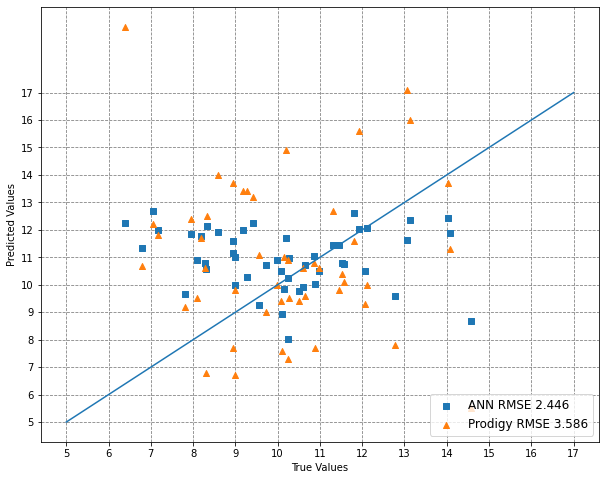

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.axes()

simbols = ['s', '^']

# Article
ax.scatter(np.multiply(test, -1),
           np.multiply(test_predictions, -1), marker=simbols[0])

# Prodigy
ax.scatter(np.multiply(test, -1),
           np.multiply(PDBind_prodigy['predicted'].astype(float).to_numpy(), -1),
           marker=simbols[1])

plt.legend(
           (f'ANN RMSE {rmse:.3f}', f'Prodigy RMSE {rmse_prodigy:.3f}'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=12)
ax.plot(range(5, 18), range(5, 18))
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.xticks(range(5, 18))
plt.yticks(range(5, 18))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


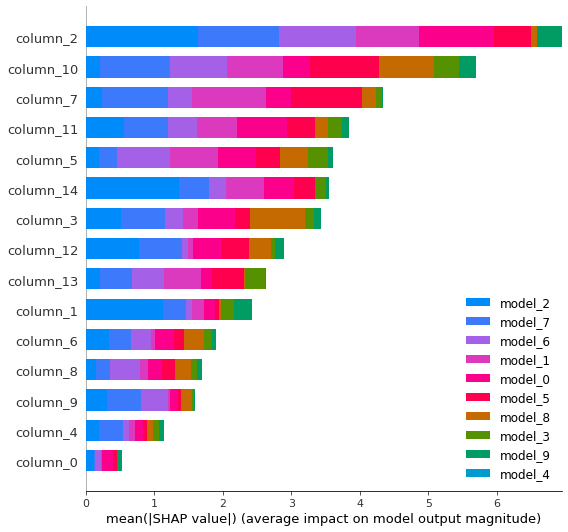

In [ ]:
import shap

n_models = 10

values = None

for i in range(n_models):
    model_ = models_dict["0"][i]


    explainer = shap.DeepExplainer(model_, umap_dict["0"][0].to_numpy())
    shap_values = explainer.shap_values(umap_dict["0"][1].to_numpy())

    values = shap_values if values is None else values + shap_values

shap.summary_plot(values, plot_type = 'bar', feature_names = umap_dict["0"][1].columns, class_names=[f"model_{i}" for i in range(n_models)])

In [ ]:
components = umap_dict["0"][1].columns

shap_dict = {}

for i in range(n_models):
    rf_resultX = pd.DataFrame(values[i], columns = components)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(components, vals)),
                                    columns=['col_name','feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'],
                                ascending=False, inplace=True)
    
    shap_dict[i] = shap_importance

shap_df = shap_dict[0]

for i in range(1, n_models):
    shap_df['feature_importance_vals'] += shap_dict[i]["feature_importance_vals"]

shap_df['feature_importance_vals'] /= n_models

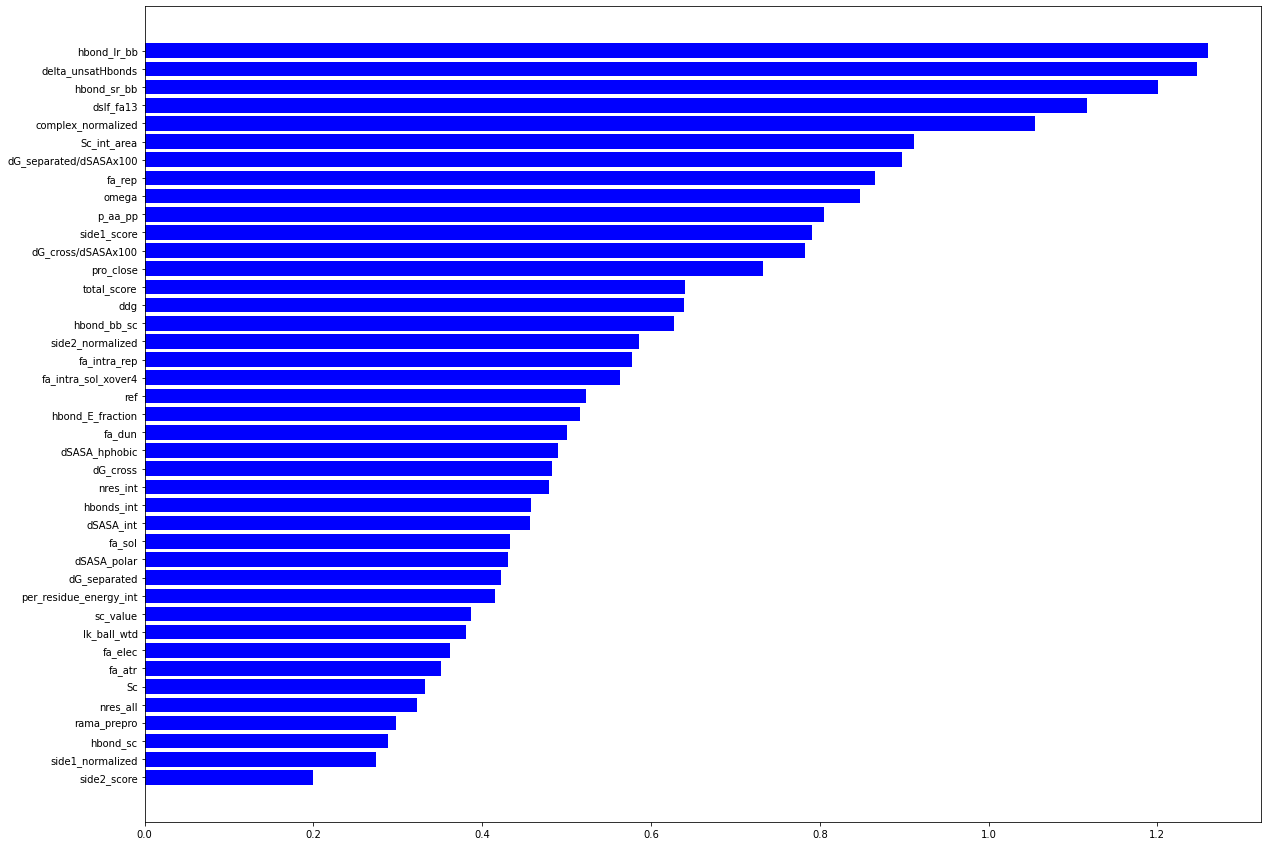

In [ ]:
features = X_train.columns

corr = pd.concat([X_train,
                 umap_dict["0"][0]],
                 axis=1).corr()

final_values = {}

for f in features:
    s = .0
    for c in components:
        score = shap_df[shap_df["col_name"] == c]
        s += score["feature_importance_vals"].iloc[0] * abs(corr[f][c])
    final_values[f] = s

sorted_dict = {}
sorted_keys = sorted(final_values, key=final_values.get, reverse=True)

for w in sorted_keys:
    sorted_dict[w] = final_values[w]

plt.figure(figsize=(20, 15))
plt.barh(list(sorted_dict.keys()), sorted_dict.values(), color='b')
plt.gca().invert_yaxis()
plt.show()